In [1]:
#Loading all necessary libraries
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import tarfile
import pandas as pd

import torch
import torchvision
import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from collections import Counter
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, utils
from skimage import io, transform
from PIL import Image as im
import torchvision.transforms as transforms

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

project_name='DL_Coursework'

In [2]:
#testing some transform code
a = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
root_dir = '/kaggle/input/deep-learning-for-msc-coursework-2021/train/train/'

In [4]:
#testing if the training csv loads properly in a datadrame
training_class_frame = pd.read_csv('/kaggle/input/deep-learning-for-msc-coursework-2021/train.csv',header=None)

In [5]:
#Printing the dataframe
print(training_class_frame)

         0           1
0       Id        Type
1        1  Connective
2        2  Connective
3        3  Connective
4        4  Connective
...    ...         ...
2186  2186      Immune
2187  2187      Cancer
2188  2188  Connective
2189  2189  Connective
2190  2190      Immune

[2191 rows x 2 columns]


In [6]:
#Selecting one cell and printing its data from the dataframe
n = 255
img_name = training_class_frame.iloc[n, 0]
cell_type = training_class_frame.iloc[n, 1]

print('Image name: {}'.format(img_name))
print('Cell type: {}'.format(cell_type))

Image name: 255
Cell type: Cancer


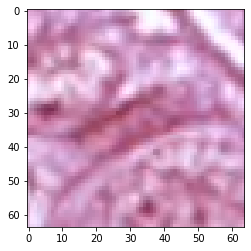

In [7]:
#Selecting the respective cell from the training image folder and displaying the specific image
def show_cells(image, cell_type):
    plt.imshow(image)

plt.figure()
image_name = str(img_name)+'.png'
show_cells(io.imread(os.path.join('/kaggle/input/deep-learning-for-msc-coursework-2021/train/train/', image_name)),cell_type)
plt.show()

In [8]:
#Custom dataset loader class and methods
class ColonCancerDataset(Dataset):
    
    def __init__(self, csv_file, root_dir, transform=None):
        self.cancer_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.cancer_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = os.path.join(self.root_dir,
                                str(self.cancer_frame.iloc[idx,0])+'.png')
        #print(idx)
        image = io.imread(img_name)
        image = image.astype(np.float32)
        cell_type = self.cancer_frame.iloc[idx, 1]
        if cell_type=='Connective':
            cell_type=0
        if cell_type=='Cancer':
            cell_type=1
        if cell_type=='Immune':
            cell_type=2
        if cell_type=='Normal':
            cell_type=3
        cell_type = np.array([cell_type])
        cell_type = cell_type.astype(np.float32).reshape(-1,1)
        idx=np.array([idx])
        idx = idx.astype(np.float32).reshape(-1,1)
        #here idx is super important as it represents the image name, as image name and number are sequential numbers"
        sample = {'image': image, 'cell_type': cell_type,'idx': idx}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [9]:
#loading the cancer dataset to test some features
cancer_dataset = ColonCancerDataset(csv_file='/kaggle/input/deep-learning-for-msc-coursework-2021/train.csv'
                                    ,root_dir= '/kaggle/input/deep-learning-for-msc-coursework-2021/train/train/')

In [10]:
#for i in range(len(cancer_dataset)):
    #sample = cancer_dataset[i]
    #print(sample)

In [11]:
#printing a single cell after its transformation fromt the dictionary created post transformation
one_cell=cancer_dataset.__getitem__(240)
if one_cell['cell_type']==1:
    one_cell['cell_type']='Cancer'
print(one_cell)

{'image': array([[[232., 200., 225.],
        [246., 227., 243.],
        [253., 247., 255.],
        ...,
        [217., 155., 201.],
        [216., 157., 201.],
        [215., 157., 199.]],

       [[222., 176., 207.],
        [241., 212., 235.],
        [255., 247., 255.],
        ...,
        [217., 155., 201.],
        [216., 156., 200.],
        [218., 159., 202.]],

       [[212., 155., 192.],
        [234., 196., 226.],
        [255., 240., 255.],
        ...,
        [215., 154., 200.],
        [215., 155., 199.],
        [218., 159., 202.]],

       ...,

       [[204., 140., 183.],
        [185., 117., 160.],
        [168.,  98., 140.],
        ...,
        [225., 179., 205.],
        [216., 173., 200.],
        [195., 152., 179.]],

       [[211., 149., 194.],
        [196., 128., 172.],
        [180., 108., 150.],
        ...,
        [248., 204., 230.],
        [240., 197., 224.],
        [210., 165., 192.]],

       [[219., 161., 206.],
        [215., 153., 196.],
      

In [12]:
#converting our arrays to tensors for processing 
#transposing the image so that the image number of channels are in the first column
class ToTensor(object):
    def __call__(self, sample):
        image, cell_type,idx = sample['image'], sample['cell_type'], sample['idx']
        image = image.transpose((2, 1, 0))
        return {'image': torch.from_numpy(image),
                'cell_type': torch.from_numpy(cell_type),
               'idx': idx}

In [13]:
#loading the training dataset with transformation
training_dataset = ColonCancerDataset(csv_file='/kaggle/input/deep-learning-for-msc-coursework-2021/train.csv'
                                    ,root_dir= '/kaggle/input/deep-learning-for-msc-coursework-2021/train/train/'
                                    ,transform=transforms.Compose([ToTensor()]))

In [14]:
#loading the test data set with transformation
test_dataset = ColonCancerDataset(csv_file='/kaggle/input/deep-learning-for-msc-coursework-2021/example.csv',
                                root_dir='/kaggle/input/deep-learning-for-msc-coursework-2021/test/test/'
                               ,transform=transforms.Compose([ToTensor()]))

In [15]:
#splitting our training data set into training and validation data
random_seed = 42
torch.manual_seed(random_seed)

val_size = 200
train_size = len(training_dataset) - val_size
train_ds, val_ds = random_split(training_dataset, [train_size, val_size])

len(train_ds), len(val_ds)

(1990, 200)

In [16]:
print(len(training_dataset))

2190


In [17]:
#checking the 
#for i in range(len(training_dataset)):
 #   sample = transformed_dataset[i]

  #  print(i, sample['image'].size(), sample['cell_type'].size(),sample['idx'])

   ## if i == 3:
     #   break

In [18]:
#loading our datasets in dataloader
#shuffling the dataset so that in every iteration the network is not fed with just single class
#making sure not to shuffle the test dataset
trainloader = DataLoader(train_ds, shuffle=True,pin_memory=True)
valloader = DataLoader(val_ds, shuffle=True,pin_memory=True)
testloader= DataLoader(test_dataset, shuffle=False,pin_memory=True)

In [19]:
#creating our network
#2 convolutional layers
#2 maxpool layers
#3 dense linear layers
#every layer except last one going through a non-linear transformation that is ReLU
#final output is of 4 (i.e. probability of selection of each class)
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5,padding=0,stride=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5,padding=0,stride=1)
        self.fc1 = nn.Linear(2704, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [20]:
#defining out loss as cross entropy as we have distinct outputs
#defining optimizer as Adam with minute learning rate after several trial and errors
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.00008)

In [21]:
#loop over the dataset multiple times
for epoch in range(2): 

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data['image'],data['cell_type']
        labels = labels.flatten()
        index=data['idx'][0]
        index=index.numpy()
        index1=index[0]
        index2=int(index1[0])
        labels = labels.type(torch.LongTensor)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        #print('Outputs',outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            #print(index2)
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 0.170
[1,   400] loss: 0.121
[1,   600] loss: 0.109
[1,   800] loss: 0.113
[1,  1000] loss: 0.101
[1,  1200] loss: 0.101
[1,  1400] loss: 0.098
[1,  1600] loss: 0.100
[1,  1800] loss: 0.103
[2,   200] loss: 0.085
[2,   400] loss: 0.073
[2,   600] loss: 0.090
[2,   800] loss: 0.084
[2,  1000] loss: 0.085
[2,  1200] loss: 0.082
[2,  1400] loss: 0.087
[2,  1600] loss: 0.075
[2,  1800] loss: 0.087
Finished Training


In [22]:
#running our validation dataset over the trained network
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in valloader:
        images=data['image']
        labels=data['cell_type']
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
     #   print(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        #if predicted==0:
         #   result.append('Connective')
        #if predicted==1:
        #    result.append('Cancer')
        #if predicted==2:
         #   result.append('Immune')
        #if predicted==3:
         #   result.append('Normal')
print('Accuracy of the network on the 200 test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 200 test images: 64 %


In [23]:
#running our test data on the trained network
#saving the final result in a dictionary

correct = 0
total = 0
test_image=[]
test_type=[]
final_result={}
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images = data['image']
        index=data['idx'][0]
        index=index.numpy()
        index1=index[0]
        index2=int(index1[0])+1
        index2=index2+10000
        test_image.append(index2)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        #print(predicted)
        if predicted==0:
            test_type.append('Connective')
        if predicted==1:
            test_type.append('Cancer')
        if predicted==2:
            test_type.append('Immune')
        if predicted==3:
            test_type.append('Normal')
    final_result["ID"]=test_image
    final_result["Type"]=test_type
    print(final_result)
            

{'ID': [10001, 10002, 10003, 10004, 10005, 10006, 10007, 10008, 10009, 10010, 10011, 10012, 10013, 10014, 10015, 10016, 10017, 10018, 10019, 10020, 10021, 10022, 10023, 10024, 10025, 10026, 10027, 10028, 10029, 10030, 10031, 10032, 10033, 10034, 10035, 10036, 10037, 10038, 10039, 10040, 10041, 10042, 10043, 10044, 10045, 10046, 10047, 10048, 10049, 10050, 10051, 10052, 10053, 10054, 10055, 10056, 10057, 10058, 10059, 10060, 10061, 10062, 10063, 10064, 10065, 10066, 10067, 10068, 10069, 10070, 10071, 10072, 10073, 10074, 10075, 10076, 10077, 10078, 10079, 10080, 10081, 10082, 10083, 10084, 10085, 10086, 10087, 10088, 10089, 10090, 10091, 10092, 10093, 10094, 10095, 10096, 10097, 10098, 10099, 10100, 10101, 10102, 10103, 10104, 10105, 10106, 10107, 10108, 10109, 10110, 10111, 10112, 10113, 10114, 10115, 10116, 10117, 10118, 10119, 10120, 10121, 10122, 10123, 10124, 10125, 10126, 10127, 10128, 10129, 10130, 10131, 10132, 10133, 10134, 10135, 10136, 10137, 10138, 10139, 10140, 10141, 10142

In [24]:
#exporting our dictionary to a csv file
output = pd.DataFrame(final_result)
output.to_csv('submission.csv', index=False)